# Training an MLP using UKF/EKF

In [2]:
import jax
import flax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from flax import linen as nn
from jax.random import PRNGKey, normal, split, uniform
from jax.ops import index_update
from tqdm.notebook import tqdm
from functools import partial

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

$$
    y=x + 2\cos(x)(-5)\sin(x) + x^3
$$

In [4]:
def f(x): return x -10 * jnp.cos(x) * jnp.sin(x) + x ** 3

In [5]:
n_obs = 200
key = PRNGKey(314)
key_x, key_y = split(key, 2)
noise_y = normal(key_y, (n_obs, ))

x = jnp.linspace(-3, 3, n_obs)
x = x + normal(key_x, (n_obs,)) * 0.1
y = f(x) + noise_y * 3

X = np.c_[x, y]
np.random.shuffle(X)
x, y = jnp.array(X.T)

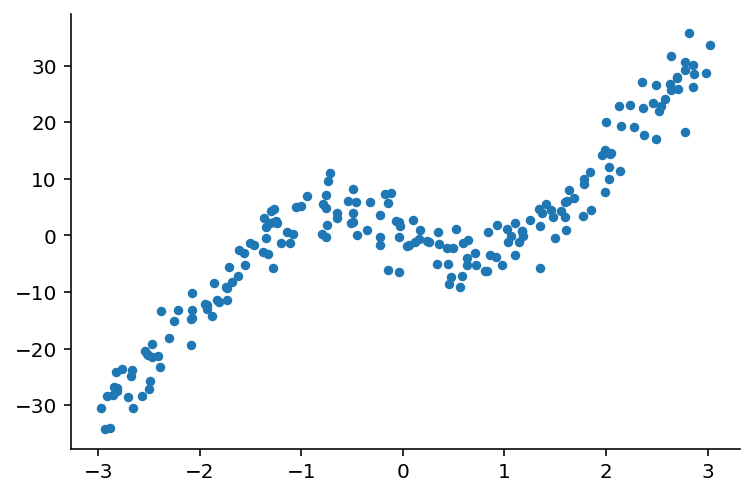

In [6]:
plt.scatter(x, y, s=14)

## MLP

In [7]:
class MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.layer1 = nn.Dense(self.n_hidden)
        self.layer2 = nn.Dense(self.n_hidden)
        self.layer_out = nn.Dense(1)
    
    def __call__(self, x):
        x = x[:, None]
        x = nn.tanh(self.layer1(x))
#         x = nn.sigmoid(self.layer2(x))
        x = self.layer_out(x)
        return x

In [8]:
def make_mse(x_batch, y_batch):
    def mse(params):
        def squared_error(x, y):
            yhat = model.apply(params, x)
            err = y - yhat
            return jnp.inner(err, err) / 2.0
        return jnp.mean(jax.vmap(squared_error)(x_batch, y_batch), axis=0).ravel()[0]
    return jax.jit(mse)

loss = make_mse(x[:,None], y)

In [9]:
class MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.layer1 = nn.Dense(self.n_hidden)
        self.layer2 = nn.Dense(self.n_hidden)
        self.layer_out = nn.Dense(1)
    
    def __call__(self, x):
        x = x[:, None]
        x = nn.tanh(self.layer1(x))
#         x = nn.sigmoid(self.layer2(x))
        x = self.layer_out(x)
        return x

In [77]:
key = PRNGKey(314)
key1, key2 = split(key, 2)

model = MLP1D(3)
params = model.init(key1, x) 
yhat = model.apply(params, x)

In [11]:
yhat = model.apply(params, x)
err = (y[:, None] - yhat)
jnp.linalg.norm(err, 2) ** 2 / (2 * len(x))

DeviceArray(110.320305, dtype=float32)

In [12]:
alpha = 0.1
n_epochs = 1000
grad_fn = jax.value_and_grad(loss)
pb = tqdm(range(n_epochs))
for i in pb:
    loss_val, grads =  grad_fn(params)
    params = jax.tree_multimap(lambda p, g: p - alpha * g, params, grads)
    if i % 100 == 0:
        desc = f"Loss step {i:03}: {loss_val:0.2f}"
        pb.set_description_str(desc)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
xtest = jnp.linspace(x.min(), x.max(), 200)
yhat_test = model.apply(params, xtest)

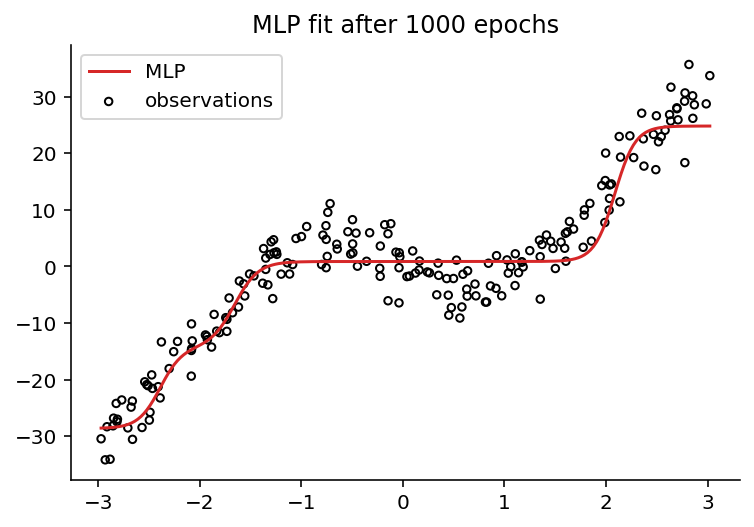

In [14]:
plt.plot(xtest, yhat_test, c="tab:red", label="MLP")
# plt.plot(x, f(x), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
plt.title(f"MLP fit after {n_epochs} epochs")
plt.legend()

# UKF Method

In [15]:
W0 = jax.tree_map(lambda p: p * 0, params)

In [16]:
jax.tree_map(lambda p: p.shape, params)

FrozenDict({
    params: {
        layer1: {
            bias: (3,),
            kernel: (1, 3),
        },
        layer_out: {
            bias: (1,),
            kernel: (3, 1),
        },
    },
})

In [17]:
def fz(W): return W
def fx(W, x): return model.apply(params, x)

In [18]:
fx(params, x[0, None])

DeviceArray([[0.8674612]], dtype=float32)

In [19]:
leafs, treedef = jax.tree_util.tree_flatten(params)

In [20]:
jax.tree_unflatten(treedef, leafs)

FrozenDict({
    params: {
        layer1: {
            bias: DeviceArray([-10.328147 , -11.112791 ,   7.0458407], dtype=float32),
            kernel: DeviceArray([[ 4.950818, -4.650125,  4.250276]], dtype=float32),
        },
        layer_out: {
            bias: DeviceArray([-1.9204588], dtype=float32),
            kernel: DeviceArray([[11.972787 ],
                         [-7.1485033],
                         [ 7.6061907]], dtype=float32),
        },
    },
})

### Flatten and reconstruction of the weights

In [21]:
leafs, treedef = jax.tree_util.tree_flatten(params)
shapes = [leaf.shape for leaf in leafs]

# Flattening of the parameters
all_params = jax.tree_map(lambda v: v.reshape(-1, 1), leafs)
all_params = jnp.concatenate(all_params)
all_params.shape 

(10, 1)

In [22]:
def flatten(pytree):
    leafs, treedef = jax.tree_util.tree_flatten(pytree)
    shapes = [leaf.shape for leaf in leafs]
    
    flatten_pytree = jax.tree_map(lambda v: v.reshape(-1, 1), leafs_jac)
    flatten_pytree = jnp.concatenate(flatten_pytree)
    return leafs, treedef, shapes, flatten_pytree

In [23]:
# cut-off points of the flattened weigths
indices = jnp.array([np.prod(s) for s in shapes]).cumsum()

# Pytree (dict) reconstruction of the weights
split_reconstruction = jnp.array_split(all_params, indices)
split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
params_reconstructed = jax.tree_unflatten(treedef, split_reconstruction)

In [24]:
def sqrtm(M):
    """
    Compute the matrix square-root of a hermitian
    matrix M. i,e, R such that RR = M

    Parameters
    ----------
    M: array(m, m)
        Hermitian matrix

    Returns
    -------
    array(m, m): square-root matrix
    """
    evals, evecs = jnp.linalg.eigh(M)
    R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
    return R

In [25]:
n_params, _ = all_params.shape
Sigma0 = jnp.eye(n_params)
Sigma_half = sqrtm(Sigma0)
Sigma_half

DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [26]:
model.apply(params_reconstructed, x[1, None])

DeviceArray([[-1.646832]], dtype=float32)

In [27]:
shapes

[(3,), (1, 3), (1,), (3, 1)]

In [28]:
treedef

PyTreeDef(CustomNode(<class 'flax.core.frozen_dict.FrozenDict'>[()], [{'params': {'layer1': {'bias': *, 'kernel': *}, 'layer_out': {'bias': *, 'kernel': *}}}]))

In [29]:
def reconstruct_weights(params_flat, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    return params


def forward_mlp(X, params_flat, model, shapes, treedef):
    """
    Run the flax-MLP with flattened parameters
    
    Parameters
    ----------
    X: array(n_obs, dim_in)
        Array of observations
    params_flat: array(n_params, )
    model: Subclass of nn.module
    shapes: list of tuples
        Each element contains the original
        shape of the MLP
    treedef: PyTreeDef
        Result of running jax.tree_util.tree_flatten
        over `model`
    
    Returns
    -------
    * array(n_obs, dim_out?)
    """
    params = reconstruct_weights(params_flat, shapes, treedef)
    yhat = model.apply(params, X)
    return yhat

In [30]:
forward_mlp(x[1, None],  all_params, model, shapes, treedef)

DeviceArray([[-1.646832]], dtype=float32)

In [31]:
model.apply(params, x[1, None])

DeviceArray([[-1.646832]], dtype=float32)

In [32]:
class UnscentedKalmanFilter:
    """
    Implementation of the Unscented Kalman Filter for discrete time systems
    """
    def __init__(self, fz, fx, Q, R, alpha, beta, kappa):
        self.fz = fz
        self.fx = fx
        self.Q = Q
        self.R = R
        self.d, _ = Q.shape
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lmbda = alpha ** 2 * (self.d + kappa) - self.d
        self.gamma = jnp.sqrt(self.d + self.lmbda)
    
    @staticmethod
    def sqrtm(M):
        """
        Compute the matrix square-root of a hermitian
        matrix M. i,e, R such that RR = M
        
        Parameters
        ----------
        M: array(m, m)
            Hermitian matrix
        
        Returns
        -------
        array(m, m): square-root matrix
        """
        evals, evecs = jnp.linalg.eigh(M)
        R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
        return R

    def filter(self, init_state, sample_obs, X):
        """
        Run the Unscented Kalman Filter algorithm over a set of observed samples.
        Parameters
        ----------
        sample_obs: array(nsamples, obs_size)
        Returns
        -------
        * array(nsamples, state_size)
            History of filtered mean terms
        * array(nsamples, state_size, state_size)
            History of filtered covariance terms
        """
        wm_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda)
                            for i in range(2 * self.d + 1)])
        wc_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda) + (1 - self.alpha ** 2 + self.beta)
                            for i in range(2 * self.d + 1)])
        
        
        nsteps, _ = sample_obs.shape
        mu_t = init_state
        Sigma_t = self.Q

        mu_hist = jnp.zeros((nsteps, self.d))
        Sigma_hist = jnp.zeros((nsteps, self.d, self.d))

        mu_hist = index_update(mu_hist, 0, mu_t)
        Sigma_hist = index_update(Sigma_hist, 0, Sigma_t)
        
        for t in range(0, nsteps):
            # TO-DO: use jax.scipy.linalg.sqrtm when it gets added to lib
            comp1 = mu_t[:, None] + self.gamma * self.sqrtm(Sigma_t)
            comp2 = mu_t[:, None] - self.gamma * self.sqrtm(Sigma_t)
            
            sigma_points = jnp.concatenate((mu_t[:, None], comp1, comp2), axis=1)

            z_bar = self.fz(sigma_points)
            mu_bar = z_bar @ wm_vec
            Sigma_bar = (z_bar - mu_bar[:, None])
            Sigma_bar = jnp.einsum("i,ji,ki->jk", wc_vec, Sigma_bar, Sigma_bar) + self.Q
            
            # Second step
            Sigma_bar_half = self.sqrtm(Sigma_bar)
            comp1 = mu_bar[:, None] + self.gamma * Sigma_bar_half
            comp2 = mu_bar[:, None] - self.gamma * Sigma_bar_half
            #sigma_points = jnp.c_[mu_bar, comp1, comp2]
            sigma_points = jnp.concatenate((mu_bar[:, None], comp1, comp2), axis=1)

            ## ****** Some important code here ******
            x_bar = self.fx(X[t, None], sigma_points).ravel()
            x_hat = x_bar @ wm_vec
            St = (x_bar - x_hat)
            # St = jnp.einsum("i,ji,ki->jk", wc_vec, St, St) + self.R
            St = (wc_vec * St ** 2).sum() + self.R

            mu_hat_component = (z_bar - mu_bar[:, None])
            x_hat_component = (x_bar - x_hat)[None, :]
            Sigma_bar_y = jnp.einsum("i,ji,ki->jk", wc_vec, mu_hat_component, x_hat_component)
            
        
            Kt = Sigma_bar_y @ jnp.linalg.inv(St)
            mu_t = mu_bar + Kt @ (sample_obs[t] - x_hat)
            Sigma_t = Sigma_bar - Kt @ St @ Kt.T
            
            mu_t = mu_t.ravel()
            mu_hist = index_update(mu_hist, t, mu_t)
            Sigma_hist = index_update(Sigma_hist, t, Sigma_t)

        return mu_hist, Sigma_hist

In [33]:
# Check whether 'unrolled' forward is the same as flax's forward
fx_p = partial(forward_mlp, model=model, shapes=shapes, treedef=treedef)
assert fx_p(x[1, None], all_params) == model.apply(params, x[1, None])

In [34]:
n_params, _ = all_params.shape

key = PRNGKey(314)
σ = 0.1
mu0 = normal(key, (n_params,)) * σ
mu0 = jnp.zeros((n_params, ))

In [35]:
Q = jnp.eye(n_params) * σ ** 2
R = jnp.eye(1) * 0.9
alpha, beta, kappa = 0.001, 2, len(all_params)
alpha, beta, kappa = 1.0, 2.0, 3 - len(all_params)

fx_p = partial(forward_mlp, model=model, shapes=shapes, treedef=treedef)
fx_vmap = jax.vmap(fx_p, in_axes=[None, 1], out_axes=(0))
ukf = UnscentedKalmanFilter(fz, fx_vmap, Q, R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(mu0, y[:, None], x)

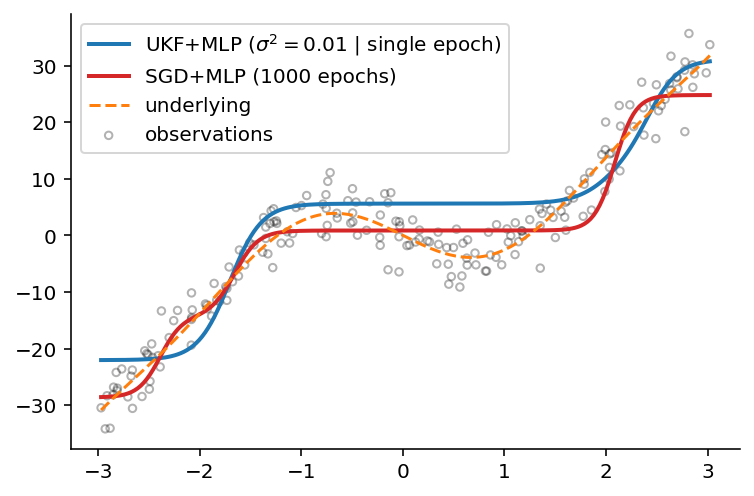

In [36]:
xtest = jnp.linspace(x.min(), x.max(), 200)
yhat_test = model.apply(params, xtest)

yhat_ukf = fx_p(xtest, mu_hist[-1])
plt.plot(xtest, yhat_ukf, label=f"UKF+MLP ($\sigma^2={σ ** 2:0.3}$ | single epoch)", linewidth=2)
plt.plot(xtest, yhat_test, c="tab:red", label=f"SGD+MLP ({n_epochs} epochs)", linewidth=2)
plt.plot(xtest, f(xtest), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations", alpha=0.3)
plt.legend()

In [37]:
jnp.mean((f(xtest) - yhat_ukf.ravel()) ** 2)

DeviceArray(22.62608, dtype=float32)

In [38]:
jnp.mean((f(xtest) - yhat_test.ravel()) ** 2)

DeviceArray(9.401651, dtype=float32)

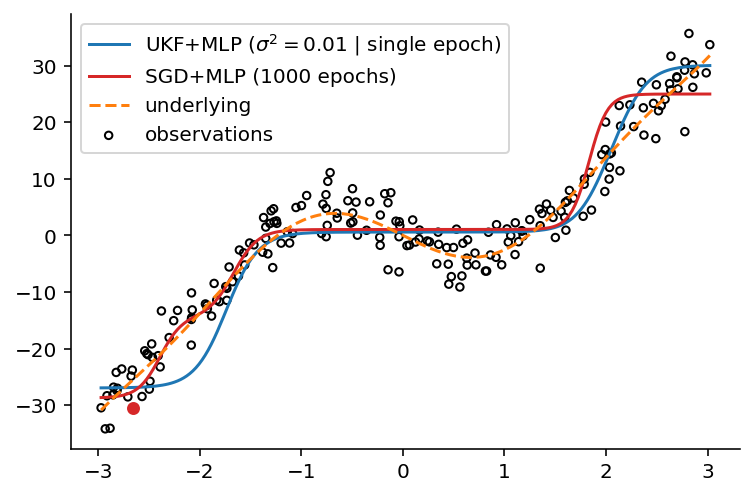

In [43]:
import matplotlib.animation as animation

nframes = n_obs
save_animation = True
fig, ax = plt.subplots()
def func(i):
    plt.cla()
    ax.plot(xtest, fx_p(xtest, mu_hist[i, :, None]), label=f"UKF+MLP ($\sigma^2={σ ** 2:0.2f}$ | single epoch)")
    ax.plot(xtest, yhat_test, c="tab:red", label=f"SGD+MLP ({n_epochs} epochs)")
    ax.plot(xtest, f(xtest), label="underlying", linestyle="--")
    ax.scatter(x[:i], y[:i], s=14, c="none", edgecolor="black", label="observations")
    ax.scatter(x[i], y[i], s=30, c="tab:red")
    ax.legend(loc="upper left")
    return ax
    
ani = animation.FuncAnimation(fig, func, frames=nframes)

if save_animation:    
    ani.save("/Users/gerardoduran/Desktop/cov_ukf4.mp4", dpi=100, bitrate=-1)

## Again without Flax

In [165]:
n_hidden = 5
def fwd_mlp(x, W):
    """
    Multi-layered perceptron with a single hidden unit
    """
    W1 = W[:n_hidden].reshape(n_hidden, 1)
    W2 = W[n_hidden: 2 * n_hidden].reshape(1, n_hidden)
    b1 = W[2 * n_hidden: 2 * n_hidden + n_hidden]
    b2 = W[-1]
    
    return W2 @ nn.tanh(W1 @ x + b1) + b2

In [166]:
n_params = 1 * n_hidden + n_hidden * 1 + n_hidden + 1
W0 = normal(key, (1 * n_hidden * n_hidden * 1 + n_hidden + 1,)) * σ
W0 = jnp.zeros((n_params,)) * σ
Q = jnp.eye(n_params) * σ ** 2
R = jnp.eye(1) * 0.9

W0_multi = normal(key, (3, 1 * n_hidden * n_hidden * 1 + n_hidden + 1)) * σ
jax.vmap(fwd_mlp, in_axes=[None, 0])(x[1, None], W0_multi)

DeviceArray([[ 0.02265],
             [ 0.0245 ],
             [-0.08618]], dtype=float32)

In [167]:
ukf = UnscentedKalmanFilter(fz, jax.vmap(fwd_mlp, in_axes=[None, 1], out_axes=(0)), Q, R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(W0, y[:, None], x)

In [170]:
mu_hist[-1]

DeviceArray([ -0.00854,   2.77939,  -3.23833,  -4.34102,   3.07327,
              -0.00503,  15.26458, -11.30505,   2.76414,   2.83583,
               0.49532,   4.75324,   7.6361 ,  -0.7598 ,  -4.14434,
               3.25248], dtype=float32)

Text(0.5, 1.0, 'UKF+MLP')

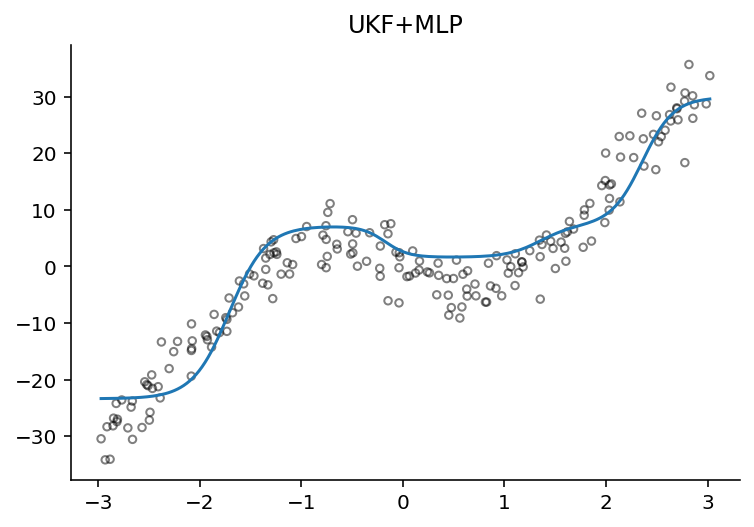

In [177]:
xtest = jnp.linspace(x.min(), x.max(), 200)
yhat_ukf = vmap_fwd_mlp(xtest[None, :], mu_hist[-1])

fig, ax = plt.subplots()
ax.plot(xtest, yhat_ukf)
ax.scatter(x, y, s=14, c="none", edgecolor="black", label="observations", alpha=0.5)
ax.set_title("UKF+MLP")

# EKF method

## Jacobian of the MLP

In [178]:
n_hidden = 5
def fwd_mlp(x, W):
    W1 = W[:n_hidden].reshape(n_hidden, 1)
    W2 = W[n_hidden: 2 * n_hidden].reshape(1, n_hidden)
    b1 = W[2 * n_hidden: 2 * n_hidden + n_hidden]
    b2 = W[-1]
    
    return W2 @ nn.tanh(W1 @ x + b1) + b2

In [179]:
n_in, n_out = 1, 1
n_params = n_in * n_hidden * n_hidden * n_out  + n_hidden + n_out
W = normal(key, (n_params,))
vmap_fwd_mlp = jax.vmap(fwd_mlp, in_axes=[1, None])

In [180]:
fwd_mlp(x[1, None], W)

DeviceArray([1.58934], dtype=float32)

In [181]:
fwd_mlp(x[1, None], W)

DeviceArray([1.58934], dtype=float32)

In [182]:
Dw = jax.jacobian(lambda W: fwd_mlp(x[1, None], W))
Dw(W)

DeviceArray([[ 0.1398 ,  0.39811,  0.2057 ,  0.87745, -0.02333,  0.88978,
              -0.79942, -0.94085,  0.0956 ,  0.98942, -0.09531, -0.27143,
              -0.14024, -0.59823,  0.0159 ,  0.     ,  0.     ,  0.     ,
               0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
               0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
               1.     ]], dtype=float32)

In [183]:
σ = 0.1
n_params, *_ = W.shape

n_params = 1 * n_hidden * n_hidden * 1 + n_hidden + 1
W0 = jnp.zeros((n_params,))

key = PRNGKey(31415)
W0 = normal(key, (n_params,)) * σ
Q = jnp.eye(n_params) * σ ** 2
R = jnp.eye(1) * 0.9

In [184]:
I = jnp.eye(n_params)

nsamples = len(x)
Wt = W0.copy()
Vt = Q.copy()

for t in tqdm(range(nsamples)):
    Wt_cond = Wt
    Vt_cond = Vt + Q
    
    Ht = jax.jacobian(lambda W: fwd_mlp(x[t, None], W))(Wt)

    Kt = Vt_cond @ Ht.T @ np.linalg.inv(Ht @ Vt_cond @ Ht.T + R)
    xt_hat = fwd_mlp(x[t, None], Wt)
    Wt = Wt + Kt @ (y[t, None] - xt_hat).ravel()
    Vt = (I - Kt @ Ht) @ Vt_cond
    
Wt

  0%|          | 0/200 [00:00<?, ?it/s]

DeviceArray([  4.0548 ,   2.39582,  -3.78033,  -3.85642,   6.2669 ,
              -0.70687,  10.32421, -11.28254,  -7.5613 ,  -1.75916,
               2.13254,   4.7796 ,   8.37527,  -5.03052,   0.80085,
              -0.00654,  -0.14522,  -0.07214,  -0.14913,   0.00051,
              -0.11073,   0.11888,  -0.01323,  -0.22294,   0.04089,
               0.10322,   0.04273,  -0.06285,   0.10697,   0.01892,
              -0.7886 ], dtype=float32)

Text(0.5, 1.0, 'EKF + MLP')

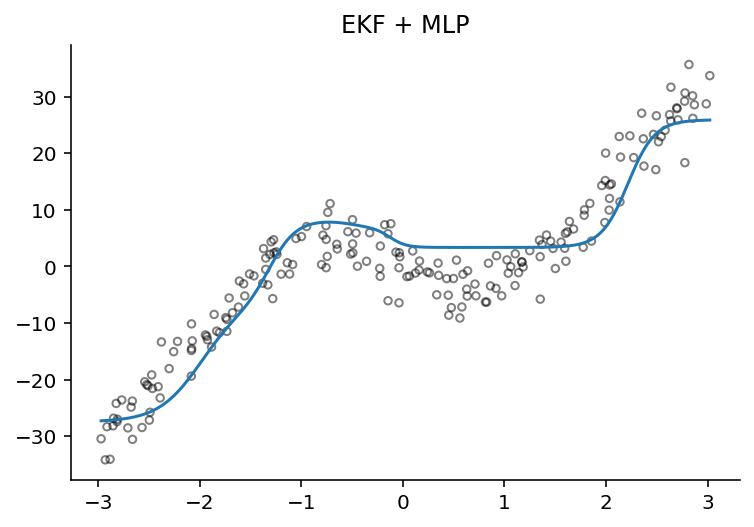

In [185]:
xtest = jnp.linspace(x.min(), x.max(), 200)
yhat_ekf = vmap_fwd_mlp(xtest[None, :], Wt)

fig, ax = plt.subplots()
ax.plot(xtest, yhat_ekf)
ax.scatter(x, y, s=14, c="none", edgecolor="black", label="observations", alpha=0.5)
ax.set_title("EKF + MLP")

### Comparing results

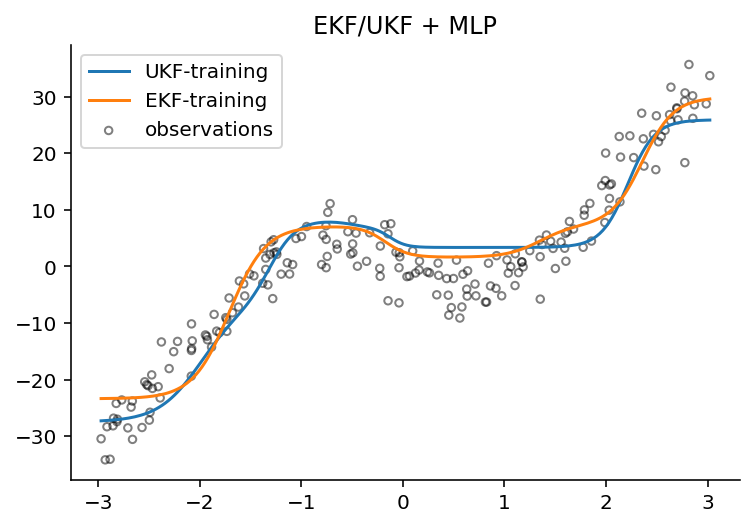

In [191]:
fig, ax = plt.subplots()
ax.plot(xtest, yhat_ekf, label="UKF-training")
ax.plot(xtest, yhat_ukf, label="EKF-training")
ax.scatter(x, y, s=14, c="none", edgecolor="black", label="observations", alpha=0.5)
ax.set_title("EKF/UKF + MLP")
ax.legend()

## References
### UKF + MLP
* https://ieeexplore.ieee.org/document/6234549
* https://juniperpublishers.com/raej/pdf/RAEJ.MS.ID.555568.pdf

### Flax
* https://github.com/google/flax/issues/735
* https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html
* https://github.com/google/flax/discussions/1393